In [1]:
from backend.models.model_nnext import ModelNNext
from configs.config import get_cfg
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# cfg = get_cfg("model_finance.yaml")
cfg = get_cfg("model_finance.yaml")

# Instantiate and print the model
model = ModelNNext(cfg)
model.prepare_data()

[*********************100%***********************]  5 of 5 completed


In [4]:
import pickle
with open('data-loaded_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [2]:
import pickle
with open('data-loaded_model.pkl', 'rb') as file:
    model = pickle.load(file)
model.cfg = get_cfg("model_finance.yaml")

In [3]:
model.build()

In [4]:
model.train()

Epoch: 0
Train - Loss: 108.6662
Valid - Loss: 56.7770
Epoch: 1
Train - Loss: 106.6209
Valid - Loss: 56.9106
Epoch: 2
Train - Loss: 104.0030
Valid - Loss: 57.6188
Epoch: 3
Train - Loss: 99.6963
Valid - Loss: 57.2554
Epoch: 4
Train - Loss: 91.2180
Valid - Loss: 63.7895
Epoch: 5
Train - Loss: 80.2439
Valid - Loss: 65.6804
Epoch: 6
Train - Loss: 69.8595
Valid - Loss: 66.5182
Stopping early due to 3 many consecutive increases in validation loss. Loading back earlier model.


[[ 7.0637621e-02  7.2882865e-03 -6.5303311e-02 -9.6568480e-02
  -2.6342851e-01]
 [ 1.2669265e-03  1.1530398e-01 -8.0462433e-02 -1.9959524e-01
   1.7147711e-01]
 [ 1.1790900e-02  1.2238357e-02 -9.2317000e-02 -7.3561832e-02
  -6.4230021e-03]
 ...
 [-2.8789222e-01 -5.4426551e-01 -6.4754641e-01 -5.9573889e-01
  -1.9158139e+00]
 [-1.6840197e-01  1.5927893e-01 -8.5173696e-03  3.2936580e-02
   3.1938127e-01]
 [ 6.7064065e-01  7.9911307e-02 -1.5378195e-01  2.3871569e-01
   4.0847425e+00]]
(250, 5)


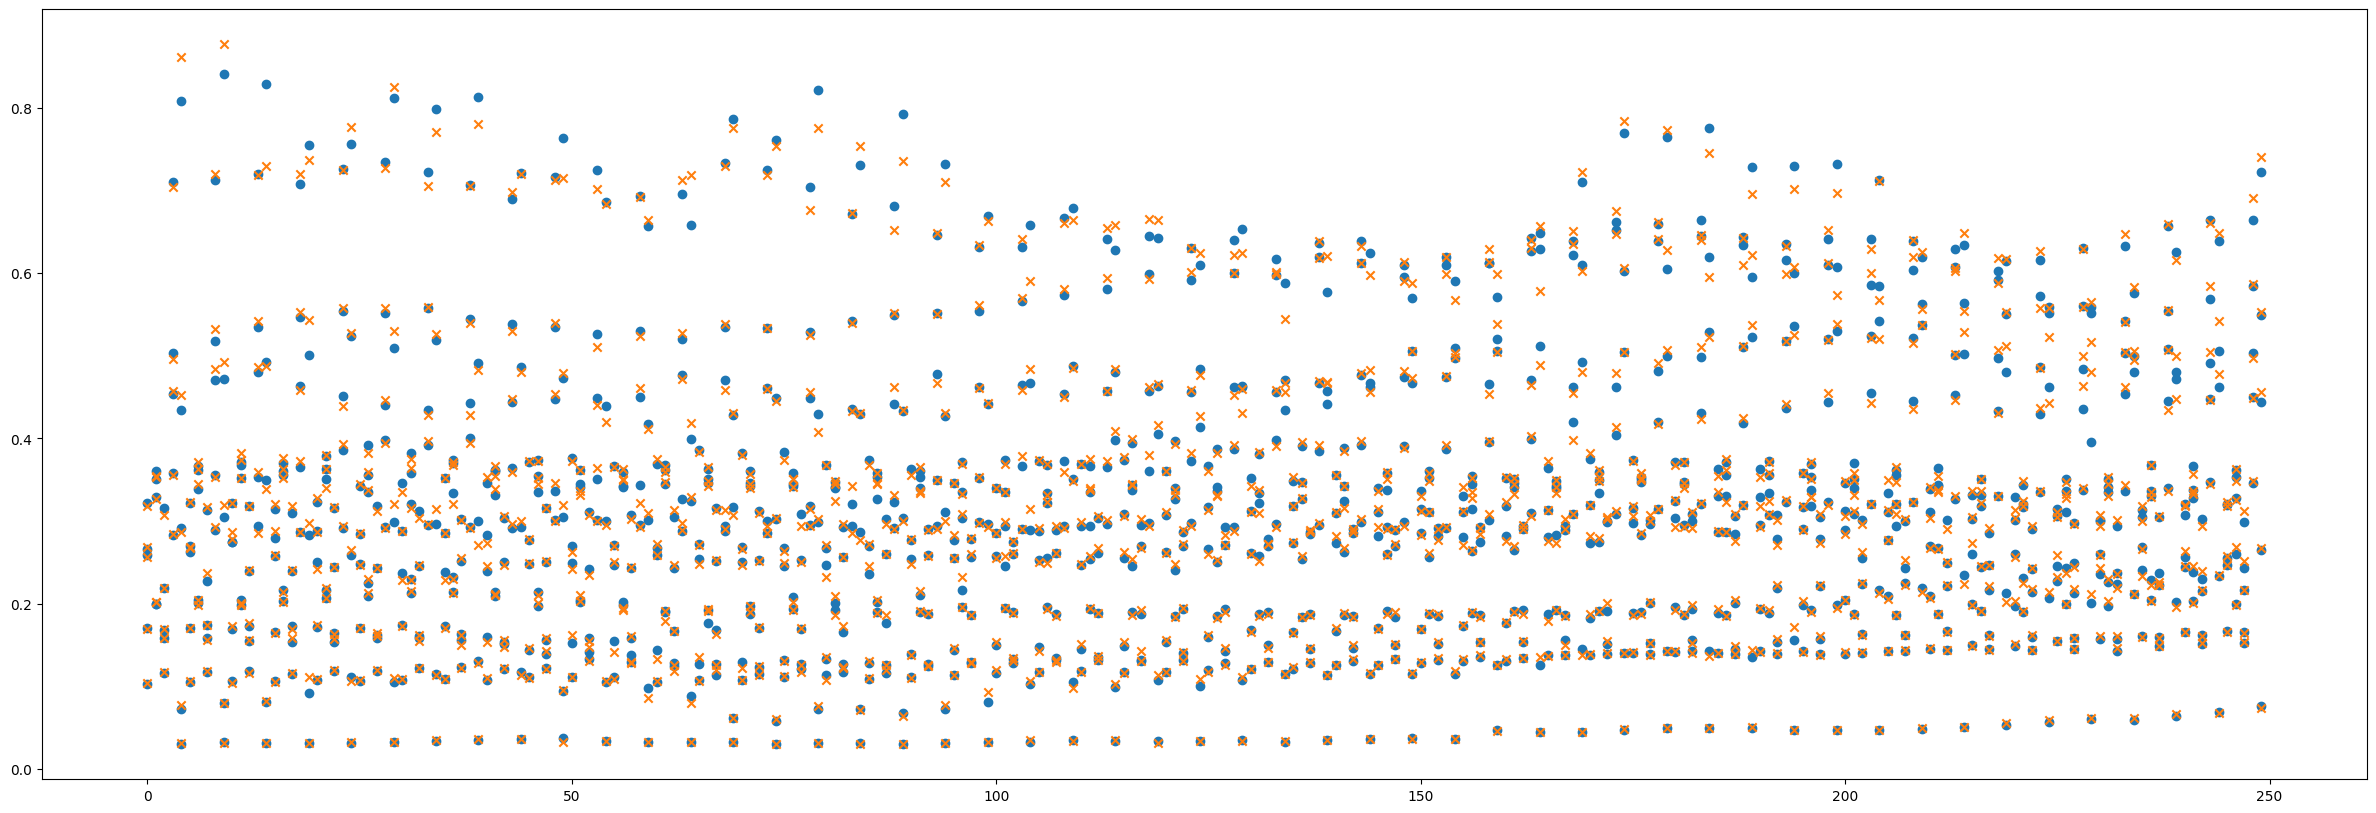

In [5]:
Ypred = model.evaluate(model.data.X_test_set.reshaped_2D_tensor()).numpy()
Ytrue = model.data.Y_test_set.ndarray
floorYtest = model.data.Ybis_test_set.ndarray

print(Ypred)
Ypred= (Ypred/100+1)*floorYtest
Ytrue= (Ytrue/100+1)*floorYtest

plt.figure(figsize=(30,10))
print(Ytrue.shape)
t = np.array([range(len(Ypred)) for i in range(len(Ypred[0]))])
plt.scatter(t,Ypred)
plt.scatter(t,Ytrue, marker='x')

# # plt.plot(range(n2,n1),full_pred_series,alpha = 0.7, linestyle='--')
plt.show()

Text(0, 0.5, 'Cumulative returns (%)')

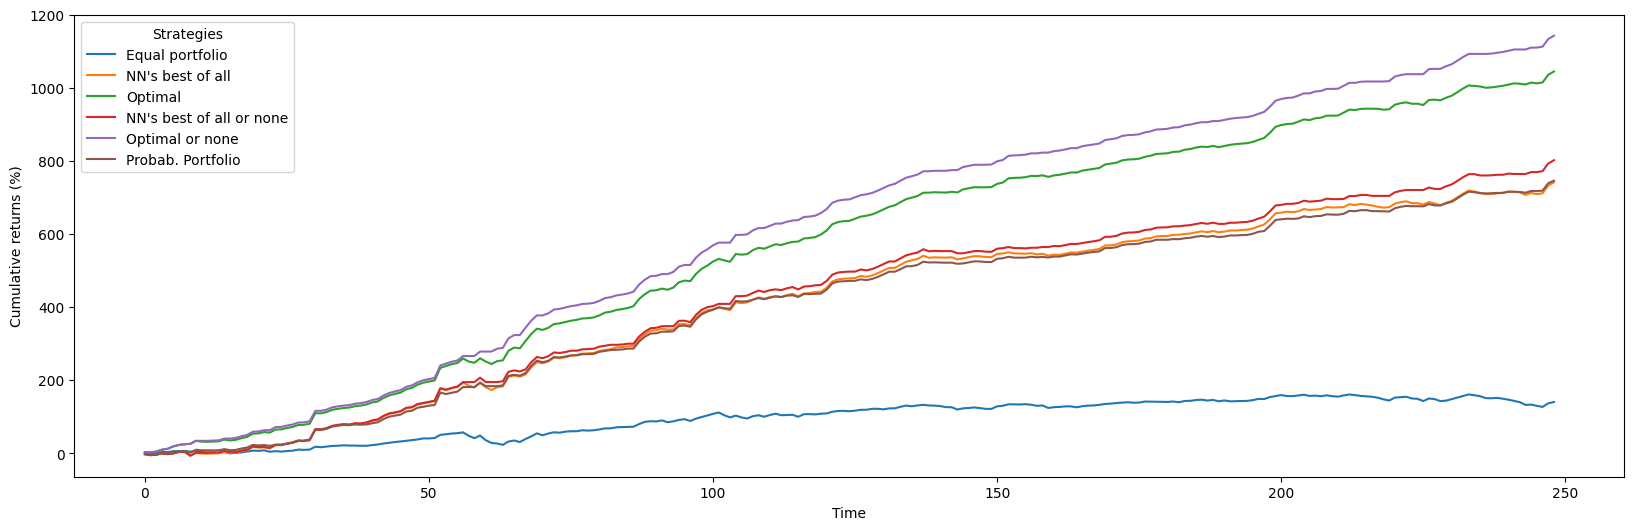

In [7]:
#### Return of the asset vs return on-off if up or down prediction.
import numpy as np
# Calculate percentage change
def pctc(arr):
  return np.diff(arr,axis = 0) / arr[:-1,:] * 100

PCa = pctc(Ytrue)
# PCb = np.copy(PCa)
# PCmax = np.copy(PCa)

temp = pctc(Ypred)
# PCb[temp<=0] = 0 # our prediction might tell us when to sell/buy (each time there is a increase/decrease pred)
# PCmax[PCa<=0] =0 # can't get more returns than when knowing the real time-series values and selling when decrease incoming.
PCmax = np.maximum.reduce(PCa,axis=1)
PCmax_and_cash = np.maximum(PCmax,0.0)

##
max_indices = np.argmax(temp, axis=1)

# PCb = PCa[:,max_indices]
PCb = PCa[np.arange(PCa.shape[0]), max_indices]

temp  = np.hstack((temp,np.zeros((temp.shape[0], 1))))
max_indices_with_zero = np.argmax(temp, axis=1)
PCa_and_cash = np.hstack((PCa,np.zeros((PCa.shape[0], 1))))

PCbBis = PCa_and_cash[np.arange(PCa_and_cash.shape[0]), max_indices_with_zero]

PCequal = np.sum(PCa,axis = 1)/len(PCa[0]) #if just having the same amount of each asset.

### invest proportionally to pred
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

PC_portfolio = np.exp(temp)
PC_portfolio = PC_portfolio/np.sum(PC_portfolio,axis=1)[:,np.newaxis]
PC_portfolio = np.sum(PCa_and_cash*PC_portfolio,axis = 1)

# cumulate the pct changes
PCequal = PCequal.cumsum()
PCb = PCb.cumsum()
PCmax = PCmax.cumsum()
PCbBis = PCbBis.cumsum()
PCmax_and_cash = PCmax_and_cash.cumsum()
PC_portfolio = PC_portfolio.cumsum()

# Plot
fig = plt.figure(figsize=(20,6))
plt.plot(PCequal)
plt.plot(PCb)
plt.plot(PCmax)
plt.plot(PCbBis)
plt.plot(PCmax_and_cash)
plt.plot(PC_portfolio)
plt.legend(['Equal portfolio',"NN's best of all",'Optimal', "NN's best of all or none", 'Optimal or none','Probab. Portfolio'], title = 'Strategies')
plt.xlabel('Time')
plt.ylabel('Cumulative returns (%)')

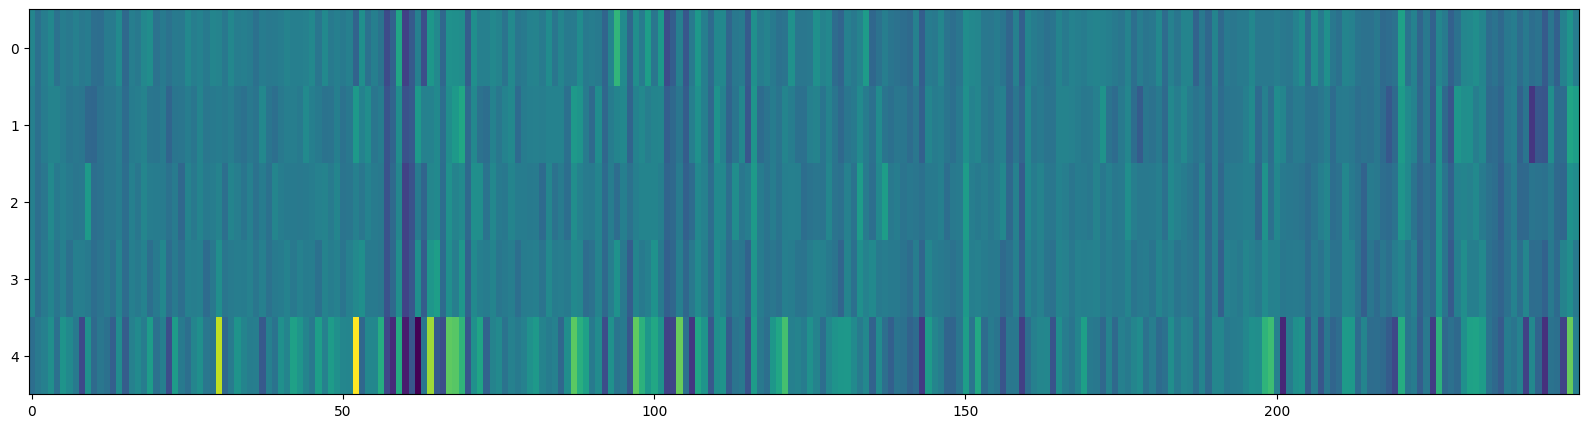

In [16]:
fig = plt.figure(figsize=(20,5))
plt.imshow(PCa.T,  aspect='auto')